# When p >> n: A Case Study in Cancer Genomics

## - No unique model "best" fits the data

## - Degrees of freedom are not sufficient 

In [36]:
from IPython.display import Image
Image(url='http://creative-wisdom.com/computer/sas/one_point.gif')

## Your dataset has 128 samples and 47,293 variables (genes)

## - What do you do?

In [37]:
# Data Imports
import numpy as np
import pandas as pd
from pandas import Series,DataFrame
from scipy.stats import norm

# Math
import math

# Plot imports
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# Preprocessing Imports
from sklearn.preprocessing import normalize

# Machine Learning Imports
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier


from sklearn.linear_model import RandomizedLogisticRegression
from sklearn.cross_validation import train_test_split

# For evaluating our ML results
from sklearn import metrics
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, auc

# For Spectral Clustering algorithms
from sklearn import cluster
from sklearn.neighbors import kneighbors_graph

# The Data

## Raw

In [39]:
# read data file
datafile = '~/Documents/THESIS/project/ICOS_DATA/breast_preprocessed.txt'
data = pd.read_table(datafile, delim_whitespace = True, 
                     dtype={'a': np.float64}, header = None)

# data dimension
print data.shape
# last 5 rows of the data
data.tail()

(47294, 129)


,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,128
47289,lysA,5.68,5.7194,5.7592,5.6898,5.7236,5.662,5.6684,5.6742,5.6669,...,5.7164,5.7175,5.7133,5.7133,5.6753,5.6679,5.6692,5.7666,5.72,5.75
47290,pheA,5.705,5.6142,5.6955,5.6227,5.6727,5.5995,5.633,5.6539,5.6511,...,5.6595,5.6292,5.6042,5.6266,5.6022,5.6709,5.6136,5.6038,5.6693,5.5818
47291,thrB,5.7077,5.7586,5.7279,5.6777,5.6761,5.7091,5.6777,5.68,5.6763,...,5.6918,5.6501,5.5772,5.6637,5.6556,5.6587,5.6987,5.6933,5.6775,5.68
47292,trpF,5.6684,5.6585,5.6337,5.6427,5.6371,5.6691,5.62,5.6199,5.6608,...,5.6392,5.6451,5.6149,5.551,5.605,5.6246,5.5404,5.6206,5.6552,5.6141
47293,y,luminal,luminal,luminal,luminal,luminal,non-luminal,non-luminal,luminal,luminal,...,luminal,luminal,luminal,non-luminal,non-luminal,luminal,luminal,luminal,non-luminal,luminal


## All cleaned up - Tidy Data

In [40]:
# extract colum names (all but last one are gene names).
colNames = data[0]
colNames = list(colNames)

# tranpose the data to have genes as columns and microarray experiment as rows
data2 = data.T.ix[1:]

# reset the index to satrt at 0
data2 = data2.reset_index(drop=True)

# add colum labels
data2.columns=colNames
data2.head()

,GI_10047089-S,GI_10047091-S,GI_10047093-S,GI_10047099-S,GI_10047103-S,GI_10047105-S,GI_10047121-S,GI_10047123-S,GI_10047133-A,GI_10047133-I,...,hmm9738-S,hmm974-S,hmm9750-S,hmm9917-S,hmm9988-S,lysA,pheA,thrB,trpF,y
0,5.3416,5.846,6.7052,6.4184,8.6651,5.7238,5.7566,6.8052,5.6885,5.8921,...,5.5959,5.8873,5.8005,5.5931,5.746,5.68,5.705,5.7077,5.6684,luminal
1,5.6259,5.8742,6.8089,6.6955,8.6113,5.8368,5.6288,7.7121,5.6911,6.0818,...,5.5832,5.7613,5.6705,5.7903,5.6111,5.7194,5.6142,5.7586,5.6585,luminal
2,5.6181,5.8026,6.6975,6.5851,8.3808,5.7835,5.8264,7.1011,5.6057,5.4915,...,5.5109,5.6742,5.7253,5.6365,5.4889,5.7592,5.6955,5.7279,5.6337,luminal
3,5.5602,5.8394,6.8386,6.7055,8.4486,5.5497,5.8045,7.6032,5.5867,5.7122,...,5.6254,5.8001,5.7344,5.6971,5.4883,5.6898,5.6227,5.6777,5.6427,luminal
4,5.5385,5.8876,6.572,6.1651,8.8246,5.7474,5.821,7.4015,5.6479,5.8412,...,5.7101,5.8066,5.6583,5.7032,5.58,5.7236,5.6727,5.6761,5.6371,luminal


# Want to classify cancer types using most relevant genes, but...




# p >> n

In [43]:
# create date set with genes only. This is the features matrix
X = data2[range(data.shape[0]-1)]
print X.shape

# make sure data type is float and not string.
X = X.astype(float)

(128, 47293)


In [44]:
# store the gene names/ids
geneNames = X.columns
# create vector with response variable
Y = data2[[-1]]
# make sure response vector is binary 0, 1.
Y = pd.get_dummies(Y)
# choose one of the equivalent response vectors.
Y = Y.ix[:,0]

# What is a good model?

## Have to Do Better than this!

### Percent of luminal positive

In [45]:
np.mean(Y)

0.65625

## Classification with Penalized Logistic Model

### The Sigmoid

\begin{equation} \label{eq:6}
E\left(Y_i\right) = \pi_i = \dfrac{1}{1+e^{\beta_{0} + \beta^T x_i}}
\end{equation}

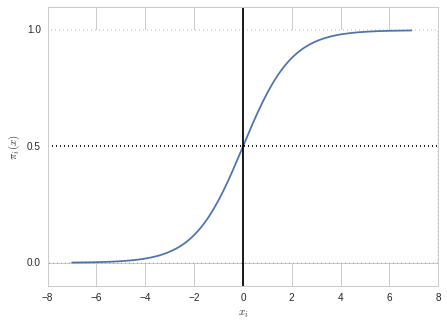

In [46]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))
z = np.arange(-7, 7, 0.1)
phi_z = sigmoid(z)
plt.figure(figsize=(7,5))
plt.plot(z, phi_z)
plt.axvline(0.0, color='k')
plt.axhspan(0.0, 1.0, facecolor='1.0', alpha=1.0, ls='dotted')
plt.axhline(y=0.5, ls='dotted', color='k')
plt.yticks([0.0, 0.5, 1.0])
plt.ylim(-0.1, 1.1)
plt.xlabel('$x_i$')
plt.ylabel('$\pi_i (x)$')
plt.savefig('sigmoid')
plt.show()

# But we have to penalize the model:

## We can solve the penalized model by maximizing the constrained likelihood, fun!

\begin{equation} \label{eq:7}
\underset{\beta_{0k},\beta_k}{max} \Biggr\{\sum_{i=1}^N 
\left[ y_i\left( \beta_{0k}+\beta_k^T x_i \right) -\log \left( 1 + e^{\beta_{0k} + \beta_k^T x_i} \right) \right]-\lambda \sum_{k = 1}^K \sum_{j = 1}^p \left(\alpha\vert\beta_{kj}\vert\ +  \left(1-\alpha\right)\beta_{kj}^2\right) \Biggr\}.
\end{equation}

In [8]:
# model definition
# logistic regression with elasticnet regularization
# l1_ratio refers to alpha and alpha refers to lamba in Hastie
log_model = SGDClassifier(loss = 'log', penalty = 'elasticnet', alpha = 0.175, 
                                l1_ratio = 0.5, fit_intercept = True)

# Significant Gene Selection Cross-Validation

## - Split into training and testing sets
## - Fit on the training set
## - Select genes using the testing set




In [9]:
#initialize the dataframes for ranking genes
selected_genes = {'col1':'gene1'}
gene_names = DataFrame(geneNames)
gene_names.columns = ['trial0']

# Initial trial column 
gene_select_count = gene_names.isin(selected_genes)
gene_coeff = DataFrame()

# Number of trials
M = 400

# IN THE LOOP
for i in range(M):
    # Split the data

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y)


    # Fit model and select significant genes

    fit_log_model = log_model.fit(X_train, Y_train)
    X_selected = fit_log_model.transform(X_test)


    # Find the indexes of significant genes

    # these are the index of the features selected by the l1 regularized logistic model
    selected_index = np.where(log_model.coef_!=0)[-1]
    # Selected genes in ith trial
    selected_genes = gene_names.loc[selected_index]

    gene_select_count['trial' + str(i)] = gene_names.isin(selected_genes)
    gene_coeff['trial' + str(i)] = Series(log_model.coef_[0])
    

In [10]:
beta_coeff = gene_coeff.mean(axis = 1)
beta_sterror = gene_coeff.std(axis = 1)
gene_imp_score = gene_coeff.mean(axis = 1).abs()
pvalue = 1-norm.cdf(np.abs(beta_coeff/beta_sterror))

In [11]:
# this creates a pandas Series with the sum of how many times a gene was selected
gene_select_summary = gene_select_count.sum(axis = 1)

In [12]:
# this data frame has the values for all genes
result = DataFrame([geneNames, gene_select_summary, gene_imp_score, beta_coeff, beta_sterror, pvalue], index = 
          ['Gene', 'Frequency', 'Score', 'Coefficient', 'Std Error', 'pvalue']).T.sort(['Frequency', 'Score'], 
                                                            ascending = False)

# And the winners are...

In [58]:
result[['Gene', 'Frequency', 'Coefficient', 'Std Error', 'pvalue']].head()

,Gene,Frequency,Coefficient,Std Error,pvalue
824,GI_4503602-S,400,3.035319,0.7452671,2.322629e-05
276,GI_21614543-S,400,-1.992362,0.6043763,0.0004893845
669,GI_38455428-S,400,1.952911,0.6752135,0.001912244
1088,GI_9951924-S,400,1.612726,0.6022487,0.00370492
428,GI_29738585-S,400,1.449006,0.4921866,0.001619913


# Who are highly correlated

In [59]:
#correlation
submat = X[['GI_4503602-S','GI_38455428-S','GI_29738585-S','GI_21614543-S','GI_9951924-S']].T

np.corrcoef(submat)

array([[ 1.        ,  0.80972455,  0.73625334, -0.59823435,  0.83457833],
       [ 0.80972455,  1.        ,  0.64928769, -0.54427371,  0.74263589],
       [ 0.73625334,  0.64928769,  1.        , -0.569731  ,  0.69178296],
       [-0.59823435, -0.54427371, -0.569731  ,  1.        , -0.5111184 ],
       [ 0.83457833,  0.74263589,  0.69178296, -0.5111184 ,  1.        ]])

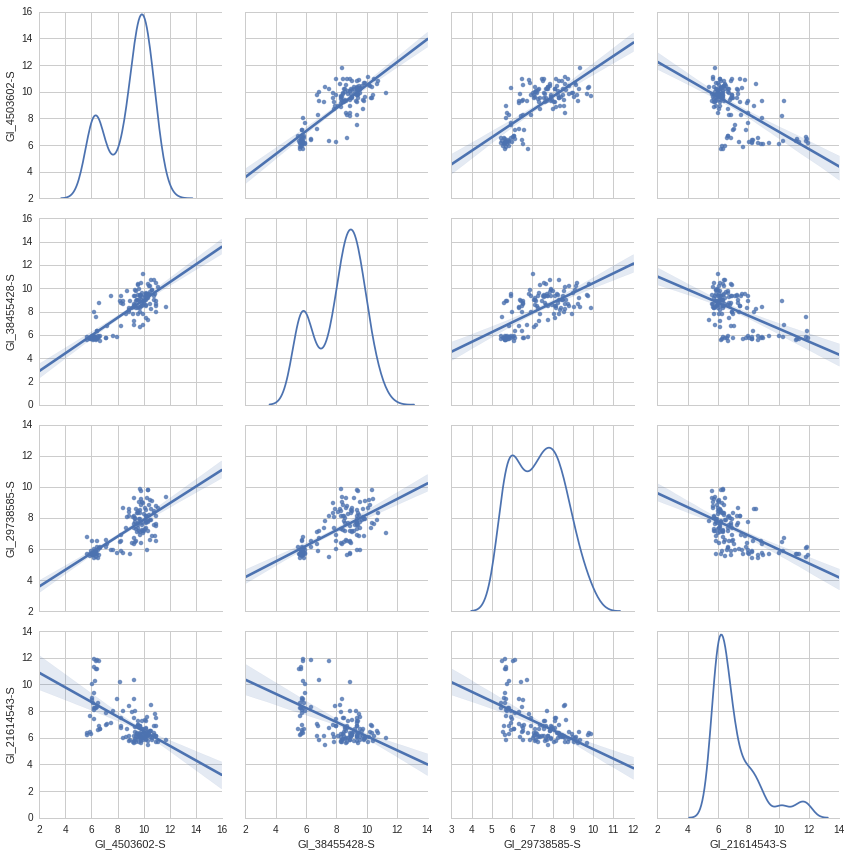

In [17]:
submat = X[['GI_4503602-S','GI_38455428-S','GI_29738585-S','GI_21614543-S']]

sns_plot = sns.pairplot(submat,kind='reg',diag_kind='kde')
sns_plot.savefig("snscorr.png")

In [52]:
# this gives the indices of selected genes according to some threshold. can use the importance score
# or the number of times selected.
selected_genes_index = gene_select_summary[gene_imp_score >= 0.001].index

In [53]:
result = DataFrame([geneNames[selected_genes_index], gene_select_summary[selected_genes_index], 
           gene_imp_score[selected_genes_index], beta_coeff[selected_genes_index], beta_sterror[selected_genes_index],
           pvalue[selected_genes_index]], index = ['Gene', 'Frequency', 'Score','Coefficient', 'Std Error', 
                                                   'pvalue']).T.sort(['Frequency', 'Score'], 
                                                                     ascending = False)

# And now new_p << old_p

In [54]:
print len(selected_genes_index)

1128


# But still greater than n

## - No problem, the elastic net can handle it
## - Main advantage over LASSO

In [61]:
#Need to create X_sel
X_sel = X[selected_genes_index]
X_sel.shape

(128, 1128)

# Lets classify now

## - Again, split into training and testing sets
## - Train the model
## - Classify on the test data

In [62]:
# Make a new log_model
#log_model2 = LogisticRegression()
log_model2 = LogisticRegression(dual = False, fit_intercept = True)

xvalacc = []
xvalROC = []
M = 400

for i in range(M):

    # Split the data
    X_train, X_test, Y_train, Y_test = train_test_split(X_sel, Y)

    # Now fit the new model
    log_model2.fit(X_train, Y_train)

    # Predict the classes of the testing data set
    class_predict = log_model2.predict(X_test)

    # Compare the predicted classes to the actual test classes
    xvalacc.append(metrics.accuracy_score(Y_test,class_predict))
    try:
        xvalROC.append(roc_auc_score(Y_test,class_predict))
    except ValueError:
        pass

# How did we do?

In [63]:
np.mean(xvalacc)

0.86781249999999999

In [64]:
np.mean(xvalROC)

0.84126029439116923

In [65]:
class_predict

array([ 0.,  0.,  1.,  1.,  0.,  0.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,
        1.,  0.,  1.,  1.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,  1.,  1.,
        0.,  0.,  0.,  0.,  1.,  1.])

In [66]:
confusion_matrix(Y_test,class_predict)

array([[12,  1],
       [ 2, 17]])

In [67]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_test,class_predict)
roc_auc = auc(false_positive_rate, true_positive_rate)

# The ROC - model evaluation

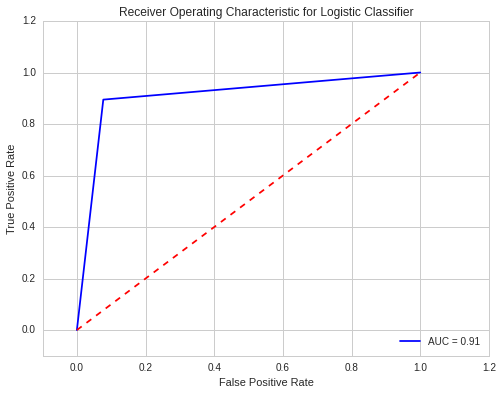

In [68]:
plt.figure(figsize=(8,6))
plt.title('Receiver Operating Characteristic for Logistic Classifier')
plt.plot(false_positive_rate, true_positive_rate,'b',label='AUC = %0.2f'% roc_auc) #roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#plt.savefig('roc.png')
plt.show()